In [1]:
import sys
import os
import json
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx 

# Add path
sys.path.append(os.path.abspath("./"))

# IMPORT MODULES
import GA as ga_ops
from GA_setup import multi_obj_GA
from pulse_generator_problem import PulseGenerator

print("Libraries loaded.")

Libraries loaded.


#### Configuration: Z1/Z2 + DsRed

In [ ]:
# CONFIGURATION
SETTINGS_FILE = "Z1Z2_settings.json"
with open(SETTINGS_FILE, "r") as f:
    settings = json.load(f)

# === THE WINNING SETTINGS ===
settings["DsRed_inhibitor"] = True    # MUST BE TRUE for Z1/Z2 to pulse (Note: The setting with False failed to pulse)
settings["n_gen"] = 50               # 50 Gens for efficiency
settings["num_processes"] = 1  
# ----------------------------

# Output Folder
timestamp = datetime.datetime.now().strftime("%Y-%m-%d")
phys_tag = "DsRed" if settings["DsRed_inhibitor"] else "Standard"
OUTPUT_FOLDER = f"results/Miner_Z1Z2_{phys_tag}_{timestamp}"

if not os.path.exists(OUTPUT_FOLDER): os.makedirs(OUTPUT_FOLDER)

print(f"--- Z1/Z2 MINER CONFIGURATION ---")
print(f"Physics:     {phys_tag}")
print(f"Output:      {OUTPUT_FOLDER}")


--- MINER CONFIGURATION ---
Physics:     DsRed
Output:      results/Miner_Z1Z2_DsRed_2026-02-11


### Modified GCAD Execution Block 
(**Note** : Careful to re-run)

In [ ]:
# 1. Initialize Problem
problem = PulseGenerator(
    promo_node=settings["promo_node"],
    dose_specs=settings["dose_specs"],
    max_part=settings["max_part"],
    inhibitor=settings["inhibitor"],
    DsRed_inhibitor=settings["DsRed_inhibitor"],
    num_dict=settings["num_dict"],
    n_gen=settings["n_gen"],
    probability_crossover=settings["probability_crossover"],
    probability_mutation=settings["probability_mutation"],
    mutate_dose=settings["mutate_dose"],
    pop=settings["pop"],
    obj_labels=settings["obj_labels"],
    max_time=settings["max_time"]
)

# 2. Sample Generation 0
print("Sampling Initial Population...")
population = ga_ops.sampling(problem.promo_node, problem.num_dict, problem.min_dose, 
                             problem.max_dose, problem.dose_interval, problem.inhibitor)

# 3. Evaluate Generation 0
obj = np.asarray([problem.func(ind[0]) for ind in population])

# 4. Run Evolution
num_circuits = int(sum(settings["num_dict"].values()))
print(">> STARTING EVOLUTION...")

multi_obj_GA(
    folder_path=OUTPUT_FOLDER,
    problem=problem,
    population=population,
    num_circuits=num_circuits,
    obj=obj,
    get_unique=False,
    plot=False
)
print(">> EVOLUTION DONE.")

#### Result Analysis

Loaded 200 Final Winners.
Loaded 1825 Total Unique Circuits Explored.
Found 2 Unique Topologies on Pareto Front.
Prevalence Stats:
  Topo 0: 156 circuits (78.0%)
  Topo 1: 44 circuits (22.0%)


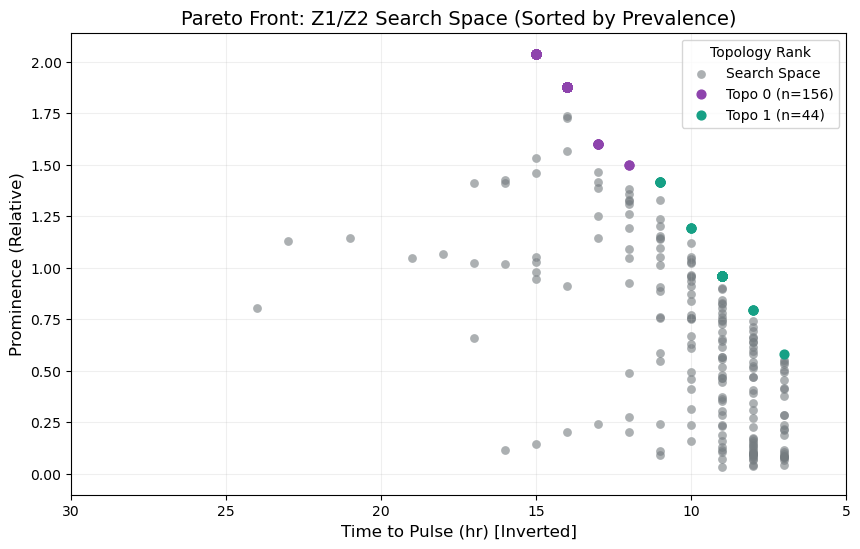

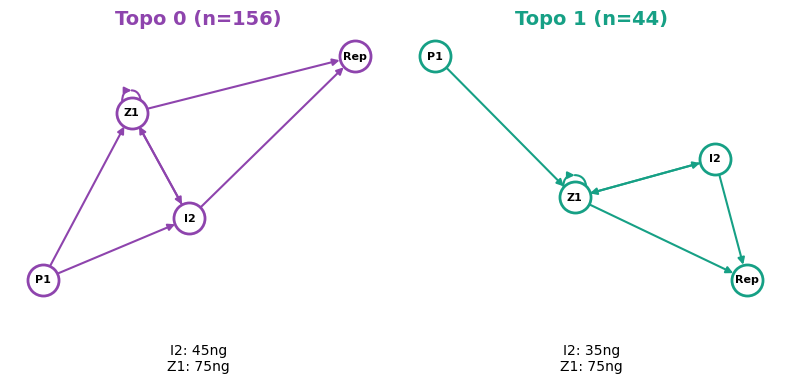

In [8]:
import matplotlib.patches as mpatches


# 1. SETUP & LOADING
folder = "results/Miner_Z1Z2_DsRed_2026-02-11" # REMEMBER TO CHECK THIS PATH

# Distinct Color Palette (Purple, Teal, Blue, Red, Orange)
topo_colors = ['#8e44ad', '#16a085', '#2980b9', '#c0392b', '#d35400', '#27ae60']

try:
    # A. Load Final Population (The Winners)
    final_df = pd.read_pickle(f"{folder}/final_objectives_df.pkl")
    with open(f"{folder}/final_population.pkl", "rb") as f:
        final_pop = pickle.load(f)
    
    # B. Load Search History (The Grey Cloud)
    history_df = pd.read_pickle(f"{folder}/unique_objectives_df.pkl")
    
    print(f"Loaded {len(final_pop)} Final Winners.")
    print(f"Loaded {len(history_df)} Total Unique Circuits Explored.")

except FileNotFoundError:
    print(f"Error: Results files not found in {folder}")


# 2. DATA PROCESSING

# Fix Signs (Minimization -> Maximization)
final_df['prominence_rel'] = -final_df['prominence_rel']
history_df['prominence_rel'] = -history_df['prominence_rel']
final_df['circuit_object'] = [ind[0] for ind in final_pop]

# A. Process Pareto Front
# 1. Signature
final_df['topology_sig'] = final_df['circuit_object'].apply(lambda c: tuple(sorted(c.edge_list)))

# 2. Filter Valid Pulses
valid_df = final_df[final_df['prominence_rel'] > 0.1].copy()

# 3. SORT BY PREVALENCE (Count occurrences)
topo_counts = valid_df['topology_sig'].value_counts()
sorted_signatures = topo_counts.index.tolist()

# 4. Map Topologies to Colors based on Rank
sig_to_id = {sig: i for i, sig in enumerate(sorted_signatures)}
sig_to_color = {sig: topo_colors[i % len(topo_colors)] for i, sig in enumerate(sorted_signatures)}

valid_df['color'] = valid_df['topology_sig'].map(sig_to_color)
valid_df['topo_id'] = valid_df['topology_sig'].map(sig_to_id)

print(f"Found {len(sorted_signatures)} Unique Topologies on Pareto Front.")
print("Prevalence Stats:")
for i, sig in enumerate(sorted_signatures):
    count = topo_counts[sig]
    prop = count / len(valid_df)
    print(f"  Topo {i}: {count} circuits ({prop:.1%})")


# 3. VISUALIZATION: PARETO FRONT (Sorted)

plt.figure(figsize=(10, 6))

# A. THE GREY CLOUD (All Explored Circuits)
# We plot the full history in light grey
plt.scatter(history_df['t_pulse'], history_df['prominence_rel'], 
            c="#757c80", s=40, alpha=0.6, linewidths=0, label='Search Space')

# B. THE PARETO FRONT (Colored by Topology, Sorted)
for sig in sorted_signatures:
    subset = valid_df[valid_df['topology_sig'] == sig]
    color = sig_to_color[sig]
    tid = sig_to_id[sig]
    count = topo_counts[sig]
    
    plt.scatter(subset['t_pulse'], subset['prominence_rel'], 
                c=color, s=40, alpha=1.0, linewidth=1.0, zorder=10,
                label=f"Topo {tid} (n={count})")

# Formatting
plt.xlim(5, 30)
plt.gca().invert_xaxis()
plt.xlabel("Time to Pulse (hr) [Inverted]", fontsize=12)
plt.ylabel("Prominence (Relative)", fontsize=12)
plt.title(f"Pareto Front: Z1/Z2 Search Space (Sorted by Prevalence)", fontsize=14)
plt.legend(title="Topology Rank", loc='upper right')
plt.grid(True, alpha=0.2)
plt.show()

# 4. VISUALIZATION: SCHEMATICS (Colored & Sorted)

num_topos = len(sorted_signatures)
cols = min(num_topos, 5)
rows = (num_topos // cols) + (1 if num_topos % cols > 0 else 0)

if rows > 0:
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    if num_topos == 1: axes = [axes]
    axes = np.array(axes).flatten()

    for i, sig in enumerate(sorted_signatures):
        ax = axes[i]
        
        # Get representative (Max Prominence)
        rep_circuit = valid_df[valid_df['topology_sig'] == sig].sort_values('prominence_rel', ascending=False).iloc[0]['circuit_object']
        color = sig_to_color[sig]
        count = topo_counts[sig]
        
        # Build Graph
        G = nx.DiGraph(rep_circuit.edge_list)
        pos = nx.spring_layout(G, seed=25)
        
        # Draw (Colored Ring matches Pareto Dot)
        nx.draw(G, pos, ax=ax,
                node_color='white', edgecolors=color, linewidths=2,
                node_size=500, with_labels=True, font_weight='bold', font_size=8,
                edge_color=color, width=1.5, arrowsize=10)
        
        ax.set_title(f"Topo {i} (n={count})", color=color, fontweight='bold', fontsize=14)
        
        # Doses
        dose_str = "\n".join([f"{k}: {v}ng" for k, v in rep_circuit.dose.items() if k!='Rep'])
        ax.text(0.5, -0.15, dose_str, transform=ax.transAxes, ha='center', va='top', fontsize=10)

    # Hide empty plots
    for j in range(i + 1, len(axes)): axes[j].axis('off')

    plt.tight_layout()
    plt.show()
